In [1]:
import os
import sys
import argparse
import logging
import torch
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.stats import multivariate_normal

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [4]:
from nnest import NestedSampler, MCMCSampler
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *
from nnest.distributions import GeneralisedNormal

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
def test(like, prior, model, nwalkers=40, init_chain=True, nested_samples=True, mcmc_steps=100, nested_fraction=0.01):
    np.random.seed(0)
    if nested_samples:
        init_samples, loglstar = like.uniform_sample(prior, 1000, nested_fraction)
    else:
        init_samples = like.sample(prior, 1000)
        loglstar = None
    model.train(init_samples, jitter=0.01, max_iters=2000)
    model.plot_samples(init_samples, plot_synthetic=False)
    sampler = MCMCSampler(like.x_dim, like, prior=prior, trainer=model, log_level=logging.INFO)
    if init_chain:
        results = sampler._ensemble_sample(mcmc_steps, nwalkers, init_state=init_samples[0:nwalkers, :], 
                                           loglstar=loglstar, stats_interval=1)
    else:
        results = sampler._ensemble_sample(mcmc_steps, nwalkers, loglstar=loglstar, stats_interval=1)
    samples, latent_samples, derived_samples, loglikes, ncall, state = results
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    flat_samples = samples.reshape((-1, like.x_dim))
    flat_latent_samples = latent_samples.reshape((-1, like.x_dim))
    ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c='r', s=5, alpha=0.5)
    ax[1].scatter(flat_latent_samples[:,0], flat_latent_samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()
    fig, ax = plt.subplots(like.x_dim, 2, figsize=(10, like.x_dim))
    for i in range(like.x_dim):
        ax[i, 0].plot(samples[0,0:1000,i])
        ax[i, 1].plot(latent_samples[0,0:1000,i])
    plt.show()
    mc = MCSamples(samples=[samples[i, :, :].squeeze() for i in range(samples.shape[0])], 
                   loglikes=[-loglikes[i, :].squeeze() for i in range(loglikes.shape[0])])
    try:
        print(mc.getEffectiveSamples())
    except:
        pass
    print(ncall)

In [7]:
nwalkers = 100

In [8]:
prior = UniformPrior(2, -15, 15)
like = Eggbox(2)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

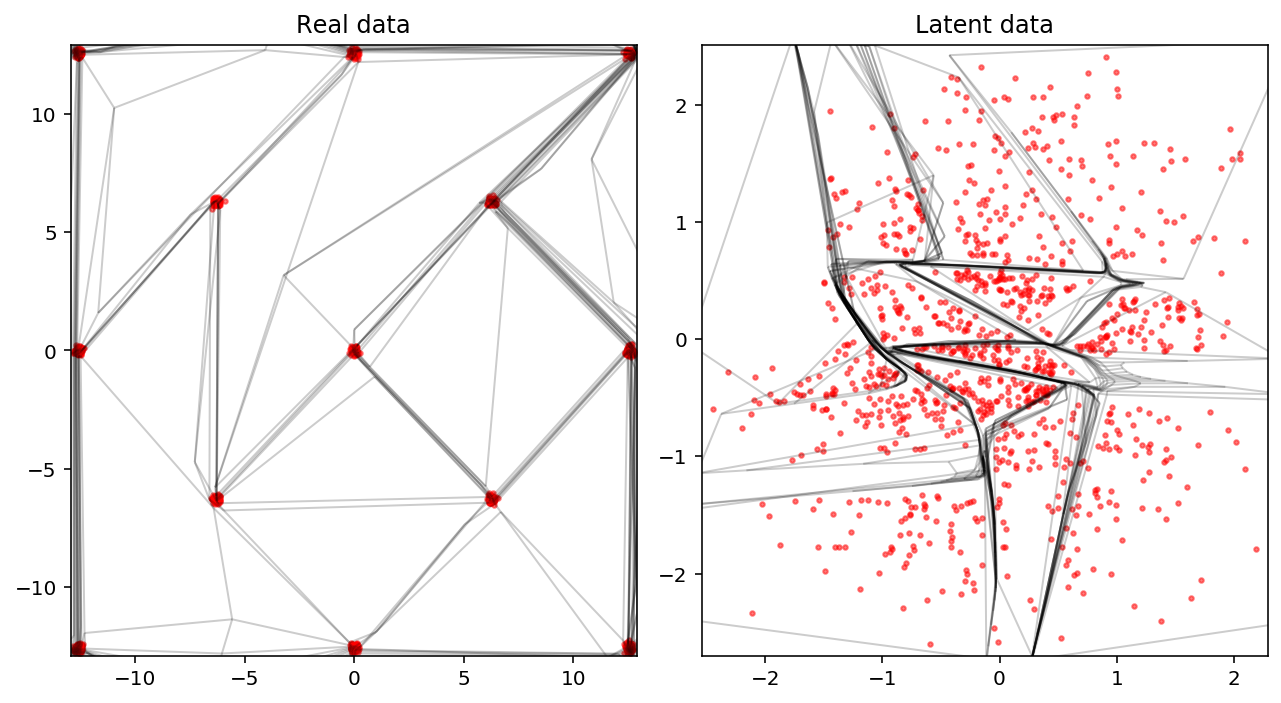

Creating directory for new run logs/test/run265
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
[nnest.sampler] [INFO] Step [1] acceptance [0.6600] ncalls [100]
[nnest.sampler] [INFO] Step [2] acceptance [0.5400] ncalls [200]
[nnest.sampler] [INFO] Step [3] acceptance [0.4967] ncalls [300]
[nnest.sampler] [INFO] Step [4] acceptance [0.5175] ncalls [400]
[nnest.sampler] [INFO] Step [5] acceptance [0.4980] ncalls [500]
[nnest.sampler] [INFO] Step [6] acceptance [0.5000] ncalls [600]
[nnest.sampler] [INFO] Step [7] acceptance [0.4971] ncalls [700]
[nnest.sampler] [INFO] Step [8] acceptance [0.4950] ncalls [800]
[nnest.sampler] [INFO] Step [9] acceptance [0.4944] ncalls [900]
[nnest.sampler] [INFO] Step [10] acceptance [0.4750] ncalls [1000]
[nnest.sampler] [INFO] Step [11] acceptance [0.4755] ncalls [1100]
[nnest.sampler] [INFO] Step [12] acceptance [0.4717] ncalls [1200]
[nnest.sampler] [INFO] Step [13] acce

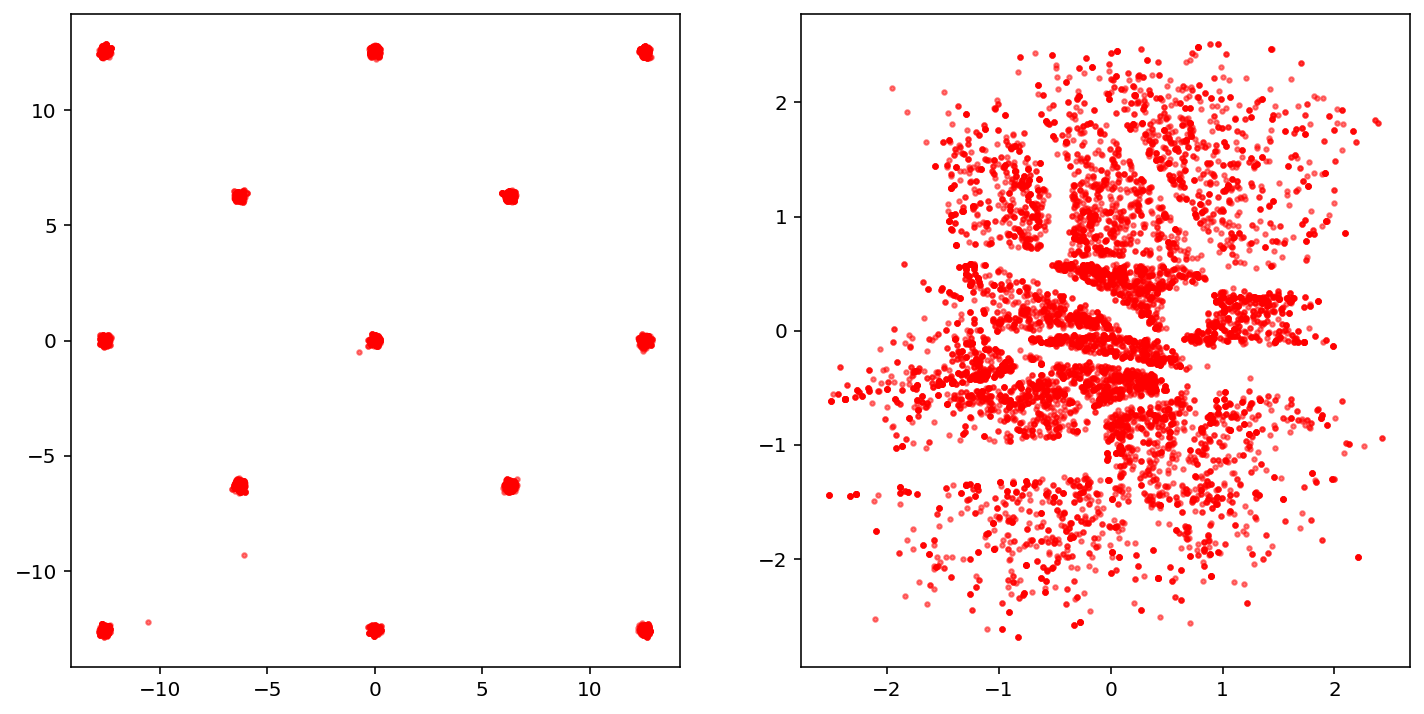

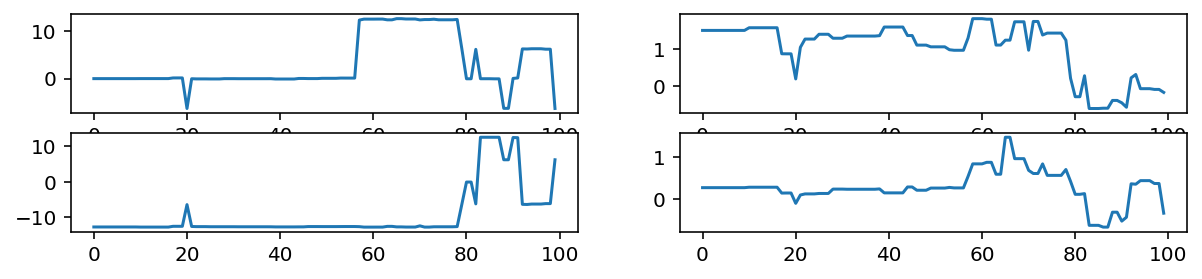

Removed no burn in
273.3363755247683
10000


In [9]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test(like, prior, model, init_chain=False, nwalkers=nwalkers, nested_samples=False)